https://physionet.org/content/sleep-edfx/1.0.0/

In [1]:
import pandas as pd
import numpy as np

import pyedflib
import mne

# Create dataloader

## Some EDF loading funcs

In [2]:
def load_signals(file_path: str) -> list:
    edf = pyedflib.EdfReader(file_path)
    start = edf.getStartdatetime()
    data = []
    for ch_idx, sig_name, freq in zip(range(len(edf.getSignalLabels())), edf.getSignalLabels(), edf.getSampleFrequencies()):
        sig = edf.readSignal(chn=ch_idx)
        idx = pd.date_range(start=start, periods=len(sig), freq=pd.Timedelta(1/freq, unit="s"))
        data += [pd.Series(sig, index=idx, name=sig_name)]
    edf.close()
    return data

In [3]:
# def load_annotations(file_path: str) -> pd.DataFrame:
#     edf = pyedflib.EdfReader(file_path)
#     annotations = edf.read_annotation()
#     df = pd.DataFrame()
    
#     # Read the onset and set as index
#     df["onset"] = [a[0] * 10**-7 for a in annotations]
#     df["onset"] = edf.getStartdatetime() + pd.TimedeltaIndex(df["onset"], unit="s")
#     df = df.rename(columns={"onset": "start"})
#     assert df["start"].is_unique
#     df.set_index("start", inplace=True)
    
#     # Read the duration and set as end time
#     df["duration"] = [int(a[1]) for a in annotations]
#     df["end"] = df.index + pd.TimedeltaIndex(df["duration"], unit="s")
#     df.drop(columns="duration", inplace=True)
    
#     # Read the description
#     df["description"] = [a[2] for a in annotations]
#     df["description"] = df["description"].str.decode("utf-8")
    
#     # Close the edf
#     edf.close()
#     return df

import mne

def load_annotations(annotation_file_path: str, psg_file_path: str) -> pd.DataFrame:
    annotations = mne.annotations.read_annotations(annotation_file_path)
    # Fore some hypnogram files there is an error when trying to get the start time
    # => Solution; get the start time from the psg file
    start_time = pyedflib.EdfReader(psg_file_path).getStartdatetime()
    df = pd.DataFrame()
    
    # Read the onset and set as index
    df["onset"] = annotations.onset
    df["onset"] = start_time + pd.TimedeltaIndex(df["onset"], unit="s")
    df = df.rename(columns={"onset": "start"})
    assert df["start"].is_unique
    df.set_index("start", inplace=True)
    
    # Read the duration and set as end time
    df["duration"] = annotations.duration
    df["end"] = df.index + pd.TimedeltaIndex(df["duration"], unit="s")
    df.drop(columns="duration", inplace=True)
    
    # Read the description
    df["description"] = annotations.description
    
    # Close the edf
    return df

In [4]:
import itertools

def annotation_to_30s_labels(annotations: pd.DataFrame) -> pd.DataFrame:
    if not (annotations.index[1:] == annotations.end[:-1]).all():
        # There is a gap in the anotations
        diffs = (annotations.index[1:] - annotations.end[:-1]).dt.seconds
        gaps = diffs[diffs != 0]
        # The end time of gap_starts indicate the start of the gap
        gap_starts = annotations[:-1][~(annotations.index[1:] == annotations.end[:-1])]
        # The start time of gap_ends indicate the end of the gap
        gap_ends = annotations[1:][~(annotations.index[1:] == annotations.end[:-1])]
        for idx, gap in enumerate(gaps):
            assert gap > 0
            gap_start_label = gap_starts["description"].values[idx]
            gap_end_label = gap_ends["description"].values[idx]
            if gap_start_label == gap_end_label:
                annotations.loc[annotations.index == gap_starts.index[idx], "end"] += pd.Timedelta(gap, unit="s")
            else:
                print("Cannot fix gap")
        
    index = pd.date_range(start=annotations.index[0], end=annotations.end[-1], freq=pd.Timedelta("30s"))
    duration = (annotations.end - annotations.index).dt.seconds.values // 30
    labels = itertools.chain.from_iterable([[l]*d for (l, d) in zip(annotations["description"], duration)])
    df = pd.DataFrame({"label": labels}, index=index[:-1])
    df.index.name = "start"
    return df

# annotation_to_30s_labels(annotations)

## Load some data

In [5]:
data_folder = "/home/jeroen/Data/sleep/sleep-edf-database-expanded-1.0.0/"

import os
os.listdir(data_folder)

['sleep-telemetry',
 'SHA256SUMS.txt',
 'SC-subjects.xls',
 'sleep-cassette',
 'RECORDS',
 'ST-subjects.xls',
 'RECORDS-v1']

In [6]:
len(os.listdir(data_folder + 'sleep-telemetry'))

88

In [7]:
size = 0 
for f in os.scandir(data_folder + 'sleep-telemetry'):
    size += os.path.getsize(f)
print(round(size / 10**6, 3), "MB")

1118.569 MB


In [8]:
sorted_files = sorted(os.listdir(data_folder + 'sleep-telemetry'))
psg_hypnogram_dict = {p: h for p, h in zip(sorted_files[::2], sorted_files[1:][::2])}
psg_hypnogram_dict

{'ST7011J0-PSG.edf': 'ST7011JP-Hypnogram.edf',
 'ST7012J0-PSG.edf': 'ST7012JP-Hypnogram.edf',
 'ST7021J0-PSG.edf': 'ST7021JM-Hypnogram.edf',
 'ST7022J0-PSG.edf': 'ST7022JM-Hypnogram.edf',
 'ST7041J0-PSG.edf': 'ST7041JO-Hypnogram.edf',
 'ST7042J0-PSG.edf': 'ST7042JO-Hypnogram.edf',
 'ST7051J0-PSG.edf': 'ST7051JA-Hypnogram.edf',
 'ST7052J0-PSG.edf': 'ST7052JA-Hypnogram.edf',
 'ST7061J0-PSG.edf': 'ST7061JR-Hypnogram.edf',
 'ST7062J0-PSG.edf': 'ST7062JR-Hypnogram.edf',
 'ST7071J0-PSG.edf': 'ST7071JA-Hypnogram.edf',
 'ST7072J0-PSG.edf': 'ST7072JA-Hypnogram.edf',
 'ST7081J0-PSG.edf': 'ST7081JW-Hypnogram.edf',
 'ST7082J0-PSG.edf': 'ST7082JW-Hypnogram.edf',
 'ST7091J0-PSG.edf': 'ST7091JE-Hypnogram.edf',
 'ST7092J0-PSG.edf': 'ST7092JE-Hypnogram.edf',
 'ST7101J0-PSG.edf': 'ST7101JE-Hypnogram.edf',
 'ST7102J0-PSG.edf': 'ST7102JE-Hypnogram.edf',
 'ST7111J0-PSG.edf': 'ST7111JE-Hypnogram.edf',
 'ST7112J0-PSG.edf': 'ST7112JE-Hypnogram.edf',
 'ST7121J0-PSG.edf': 'ST7121JE-Hypnogram.edf',
 'ST7122J0-PS

In [9]:
train = sorted(psg_hypnogram_dict.keys())[:-8]
test = sorted(psg_hypnogram_dict.keys())[-8:]
len(train), len(test)

(36, 8)

In [10]:
file_folder = data_folder + 'sleep-telemetry/'

In [11]:
data = load_signals(file_folder + train[0])
annotations = load_annotations(file_folder + psg_hypnogram_dict[train[0]], file_folder + train[0])

# EDA + pipeline (for 1 patient)

In [12]:
import sys

sys.path.append("../../../Git/plotly-dynamic-resampling/")

from plotly_dynamic_resampling import PlotlyDataMirror
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [13]:
idxs = [s.name for s in data[:-1]]

fig = PlotlyDataMirror(make_subplots(rows=5, cols=1, shared_xaxes=True, subplot_titles=idxs + ["Hypnogram"], vertical_spacing=0.05))

for idx, s in enumerate(data[:-1], 1):
    fig.add_trace(
        go.Scattergl(x=[], y=[], name=s.name),
        orig_x=s.index,
        orig_y=s.values,
        row=idx, col=1
    )


fig.add_trace(
    go.Scattergl(x=[], y=[], name="Hypnogram"),
    orig_x=annotation_to_30s_labels(annotations).index,
    orig_y=annotation_to_30s_labels(annotations)["label"],
    row=5, col=1
)

fig.update_layout(height=150*5)

fig.show_dash()

Dash app running on http://127.0.0.1:8050/


## Process the signals

In [14]:
import sys

sys.path.append("../../../Git/tsflex")

In [15]:
## Processing
from tsflex.processing import SeriesProcessor, SeriesPipeline

from scipy.signal import butter, lfilter
from scipy.fft import fft


def butter_bandpass_filter(sig, lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    y = lfilter(b, a, sig)
    return y

def clipper(sig, min_q=0, max_q=1):
    return sig.clip(sig.quantile(min_q), sig.quantile(max_q))

eeg_bandpass = SeriesProcessor(function=butter_bandpass_filter, series_names=["EEG Fpz-Cz", "EEG Pz-Oz", "EOG horizontal"], lowcut=0.53, highcut=15, fs=100)
emg_clipper = SeriesProcessor(function=clipper, series_names="EMG submental", min_q=0.02)

process_pipe = SeriesPipeline(
    [
        eeg_bandpass,
        emg_clipper,
    ]
)

process_pipe

[
	butter_bandpass_filter {'lowcut': 0.53, 'highcut': 15, 'fs': 100} :  ('EEG Fpz-Cz',) ('EEG Pz-Oz',) ('EOG horizontal',)
	clipper {'min_q': 0.02} :  ('EMG submental',)
]

In [16]:
%%time
data_processed = process_pipe.process(data, return_all_series=False)

CPU times: user 227 ms, sys: 24.6 ms, total: 252 ms
Wall time: 215 ms


In [17]:
for s in data_processed:
    idx = idxs.index(s.name.split('_')[-1]) + 1
    fig.add_trace(
        go.Scattergl(x=[], y=[], name=s.name + " processed"),
        orig_x=s.index,
        orig_y=s.values,
        row=idx, col=1
    )

fig.show_dash()

Dash app running on http://127.0.0.1:8050/


## Extract the features

In [18]:
from tsflex.features import MultipleFeatureDescriptors, FeatureCollection, FuncWrapper
from seglearn.feature_functions import emg_features, base_features
from tsflex.features.integrations import seglearn_wrapper

from scipy.fft import fft

# Inspired by; https://github.com/jordan-bird/eeg-feature-generation/blob/master/code/EEG_feature_extraction.py
def fft_feats(s: np.ndarray, freq, notch_f=50, ntop=10):
    N = len(s)
    T = freq / N 
    
    # Compute the (absolute values of the) FFT
    # Extract only the first half of each FFT vector, since all the information
    # is contained there (by construction the FFT returns a symmetric vector).
    fft_values = np.abs(fft(s, axis = 0))[0:N//2] * 2 / N

    # Compute the corresponding frequencies of the FFT components
    freqs = np.linspace(0.0, 1.0 / (2.0 * T), N//2)

    # Remove mains frequency component(s)
    indx = np.where(np.abs(freqs - notch_f) <= 1)
    fft_values = np.delete(fft_values, indx, axis = 0)
    freqs = np.delete(freqs, indx)

    # Extract top N frequencies
    indx = np.argsort(fft_values, axis = 0)[::-1]
    indx = indx[:ntop]
    topn_freqs = freqs[indx].flatten(order = 'F')
    
    return topn_freqs


basic_feats = MultipleFeatureDescriptors(
        functions=[seglearn_wrapper(f, f_name) for f_name, f in base_features().items()],
        series_names=["EEG Fpz-Cz", "EEG Pz-Oz", "EOG horizontal"],
        windows=["30s", "60s", "120s"],
        strides="30s",
    )

emg_feats = MultipleFeatureDescriptors(
        functions=[seglearn_wrapper(f, f_name) for f_name, f in emg_features().items()],
        series_names=["EMG submental"],
        windows=["30s", "60s", "120s"],
        strides="30s",
    )

eeg_feat = MultipleFeatureDescriptors(
        functions=FuncWrapper(fft_feats, output_names=[f"freq_{i}" for i in range(1,11)], freq=100),
        series_names=["EEG Fpz-Cz", "EEG Pz-Oz", "EOG horizontal"],
        windows=["30s", "60s"],
        strides="30s",
)

feature_collection = FeatureCollection([basic_feats, emg_feats, eeg_feat])
feature_collection

EEG Fpz-Cz: (
	win: 30s   , stride: 30s: [
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__mean, ['mean'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__median, ['median'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__abs_energy, ['abs_energy'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__std, ['std'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__var, ['var'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__minimum, ['min'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__maximum, ['max'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__skew, ['skew'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__kurt, ['kurt'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__mse, ['mse'], {}),
		FeatureDescriptor - func: FuncWrapper([seglearn_wrapped]__mean_crossings, ['mnx'], {}),
		FeatureDescriptor - func: FuncWrapper(fft

In [19]:
%%time
feats = feature_collection.calculate(data, return_df=True)
feats

CPU times: user 579 ms, sys: 149 ms, total: 728 ms
Wall time: 3.72 s


,EEG Fpz-Cz__min__w=30s_s=30s,EEG Fpz-Cz__max__w=30s_s=30s,EEG Fpz-Cz__abs_energy__w=30s_s=30s,EEG Fpz-Cz__mean__w=30s_s=30s,EEG Fpz-Cz__std__w=30s_s=30s,EEG Fpz-Cz__var__w=30s_s=30s,EEG Fpz-Cz__mnx__w=30s_s=30s,EEG Fpz-Cz__mean__w=1m_s=30s,EEG Fpz-Cz__abs_energy__w=1m_s=30s,EEG Fpz-Cz__median__w=30s_s=30s,...,EOG horizontal__freq_5__w=1m_s=30s,EOG horizontal__freq_6__w=1m_s=30s,EOG horizontal__freq_7__w=1m_s=30s,EOG horizontal__freq_8__w=1m_s=30s,EOG horizontal__freq_9__w=1m_s=30s,EOG horizontal__freq_10__w=1m_s=30s,EMG submental__slope_sign_changes__w=2m_s=30s,EMG submental__willison_amplitude__w=2m_s=30s,EMG submental__zero_crossings__w=2m_s=30s,EOG horizontal__mse__w=2m_s=30s
1994-07-12 23:00:30,-2812.488555,375.206006,1.393122e+07,-8.189831,6.765107e+01,4.576667e+03,29.0,NaN,NaN,-0.183117,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1994-07-12 23:01:00,-376.304706,798.205457,8.378685e+07,-14.405420,1.664976e+02,2.772143e+04,64.0,-11.297626,9.771808e+07,-45.229811,...,0.080027,0.050017,0.150050,0.120040,0.100033,0.070023,NaN,NaN,NaN,NaN
1994-07-12 23:01:30,-118.842703,227.247757,8.837607e+06,-7.902704,5.369745e+01,2.883416e+03,233.0,-11.154062,9.262446e+07,-8.972716,...,0.110037,0.030010,0.020007,0.210070,0.170057,0.130043,NaN,NaN,NaN,NaN
1994-07-12 23:02:00,-107.123238,211.865959,3.720553e+06,2.475981,3.512910e+01,1.234054e+03,387.0,-2.713361,1.255816e+07,-2.746750,...,0.140047,0.060020,0.180060,0.200067,0.110037,0.150050,8895.0,11999.0,11999.0,1.841463e+08
1994-07-12 23:02:30,-156.930965,93.206372,8.054288e+06,-7.832021,5.121935e+01,2.623422e+03,175.0,-2.678020,1.177484e+07,0.549350,...,0.140047,0.150050,0.000000,0.130043,0.110037,0.090030,8304.0,11999.0,11999.0,1.259940e+08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994-07-13 08:56:00,-2353.232009,-2353.232009,1.661310e+10,-2353.232009,4.547474e-13,2.067952e-25,0.0,-2353.232009,3.322621e+10,-2353.232009,...,0.200067,0.300100,0.350117,0.450150,0.400133,0.550183,11998.0,11999.0,11999.0,6.645241e+10
1994-07-13 08:56:30,-2353.232009,-2353.232009,1.661310e+10,-2353.232009,4.547474e-13,2.067952e-25,0.0,-2353.232009,3.322621e+10,-2353.232009,...,0.200067,0.300100,0.350117,0.450150,0.400133,0.550183,11998.0,11999.0,11999.0,6.645241e+10
1994-07-13 08:57:00,-2353.232009,-2353.232009,1.661310e+10,-2353.232009,4.547474e-13,2.067952e-25,0.0,-2353.232009,3.322621e+10,-2353.232009,...,0.200067,0.300100,0.350117,0.450150,0.400133,0.550183,11998.0,11999.0,11999.0,6.645241e+10
1994-07-13 08:57:30,-2353.232009,-2353.232009,1.661310e+10,-2353.232009,4.547474e-13,2.067952e-25,0.0,-2353.232009,3.322621e+10,-2353.232009,...,0.200067,0.300100,0.350117,0.450150,0.400133,0.550183,11998.0,11999.0,11999.0,6.645241e+10


# Pipeline for all patients

In [20]:
from tqdm.auto import tqdm

df_feats = []
for psg_file, hypnogram_file in tqdm(psg_hypnogram_dict.items()):
    # Load the data, process the data and extract features
    data = load_signals(file_folder + psg_file)
    data_processed = process_pipe.process(data)
    df_feat = feature_collection.calculate(data_processed, return_df=True, window_idx="begin")
    # Add the labels (and reduce features to only data for which we have labels)
    annotations = load_annotations(file_folder + hypnogram_file, file_folder + psg_file)
    annotations = annotation_to_30s_labels(annotations)
    df_feat = df_feat.merge(annotations, left_index=True, right_index=True)
    # Add the file name
    df_feat["psg_file"] = psg_file
    # Collect the dataframes
    df_feats += [df_feat]
    
df_feats = pd.concat(df_feats)
df_feats.rename(columns={"description": "label"}, inplace=True)

In [21]:
df_feats.to_parquet("telemetry_features.parquet")

In [20]:
df_feats = pd.read_parquet("telemetry_features.parquet")

In [21]:
df_feats

,EEG Fpz-Cz__abs_energy__w=30s_s=30s,EEG Fpz-Cz__mean__w=30s_s=30s,EEG Fpz-Cz__min__w=30s_s=30s,EEG Fpz-Cz__max__w=30s_s=30s,EEG Fpz-Cz__std__w=30s_s=30s,EEG Fpz-Cz__var__w=30s_s=30s,EEG Fpz-Cz__mean__w=1m_s=30s,EEG Fpz-Cz__mnx__w=30s_s=30s,EEG Fpz-Cz__median__w=30s_s=30s,EEG Fpz-Cz__abs_energy__w=1m_s=30s,...,EOG horizontal__freq_7__w=1m_s=30s,EOG horizontal__freq_8__w=1m_s=30s,EOG horizontal__freq_9__w=1m_s=30s,EOG horizontal__freq_10__w=1m_s=30s,EOG horizontal__skew__w=2m_s=30s,EMG submental__willison_amplitude__w=2m_s=30s,EMG submental__zero_crossings__w=2m_s=30s,EOG horizontal__mse__w=2m_s=30s,label,psg_file
1994-07-12 23:00:00,4.935362e+06,0.078109,-920.915417,769.107829,40.560010,1645.114439,-0.367327,111.0,1.654293e-09,1.187101e+07,...,0.320107,0.370123,0.870290,0.340113,-4.185375,11999.0,11999.0,3.249099e+07,Sleep stage W,ST7011J0-PSG.edf
1994-07-12 23:00:30,6.935646e+06,-0.812762,-263.206780,249.858810,48.075164,2311.221429,-0.049890,160.0,-4.650092e-01,9.455215e+06,...,0.770257,0.360120,0.570190,0.590197,0.070394,11999.0,11999.0,2.082454e+07,Sleep stage W,ST7011J0-PSG.edf
1994-07-12 23:01:00,2.519569e+06,0.712982,-102.089503,141.795611,28.971504,839.348041,0.193926,218.0,-6.399587e-02,3.668126e+06,...,0.400133,0.730243,0.740247,0.380127,0.201755,11999.0,11999.0,1.106057e+07,Sleep stage W,ST7011J0-PSG.edf
1994-07-12 23:01:30,1.148557e+06,-0.325129,-125.458898,88.265500,19.563908,382.746477,0.028533,305.0,2.832337e-01,1.561270e+06,...,0.530177,0.560187,0.430143,0.440147,0.468826,11999.0,11999.0,5.631895e+06,Sleep stage W,ST7011J0-PSG.edf
1994-07-12 23:02:00,4.127131e+05,0.382195,-41.475728,54.738822,11.722839,137.424964,0.168087,321.0,2.695065e-01,5.213993e+05,...,0.300100,0.480160,0.730243,0.420140,-0.442800,11999.0,11999.0,1.700902e+06,Sleep stage W,ST7011J0-PSG.edf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1994-09-16 07:42:00,4.974673e+05,-0.007230,-64.584935,50.967380,12.877203,165.822368,-0.002406,267.0,-1.934317e-01,1.514153e+06,...,0.660220,0.730243,0.720240,0.820273,1.478186,11999.0,11999.0,8.439695e+07,Sleep stage 2,ST7242J0-PSG.edf
1994-09-16 07:42:30,1.016686e+06,0.002417,-79.045928,102.408404,18.409111,338.895353,0.230557,231.0,2.216807e-01,4.700960e+06,...,0.440147,0.430143,0.450150,0.420140,-1.287150,11999.0,11999.0,1.777167e+08,Sleep stage 2,ST7242J0-PSG.edf
1994-09-16 07:43:00,3.684274e+06,0.458697,-182.971955,181.730929,35.041132,1227.880926,-0.060140,205.0,4.918413e-01,1.427802e+07,...,0.580193,0.430143,0.470157,0.800267,-1.291154,11999.0,11999.0,1.773615e+08,Sleep stage W,ST7242J0-PSG.edf
1994-09-16 07:43:30,1.059374e+07,-0.578976,-264.354724,287.803678,59.421480,3530.912241,-0.224601,177.0,-4.807364e-01,1.019128e+08,...,0.840280,0.600200,0.550183,0.540180,-2.629307,11999.0,11999.0,1.351110e+08,Sleep stage W,ST7242J0-PSG.edf


In [22]:
# Postprocess labels
df_feats.loc[df_feats["label"] == "Sleep stage 4", "label"] = "Sleep stage 3"
df_feats.loc[df_feats["label"] == "Movement time", "label"] = "Sleep stage W"

df_train = df_feats[df_feats.psg_file.isin(train)]
df_test = df_feats[df_feats.psg_file.isin(test)]
print(df_train.shape, df_test.shape)

(34917, 188) (7922, 188)


## EDA on labels

<AxesSubplot:>

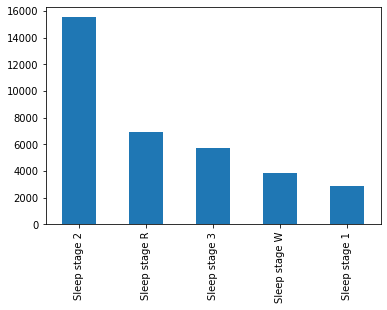

In [23]:
df_train["label"].value_counts().plot(kind="bar")

=> There is quite some label imbalance

## EDA on features

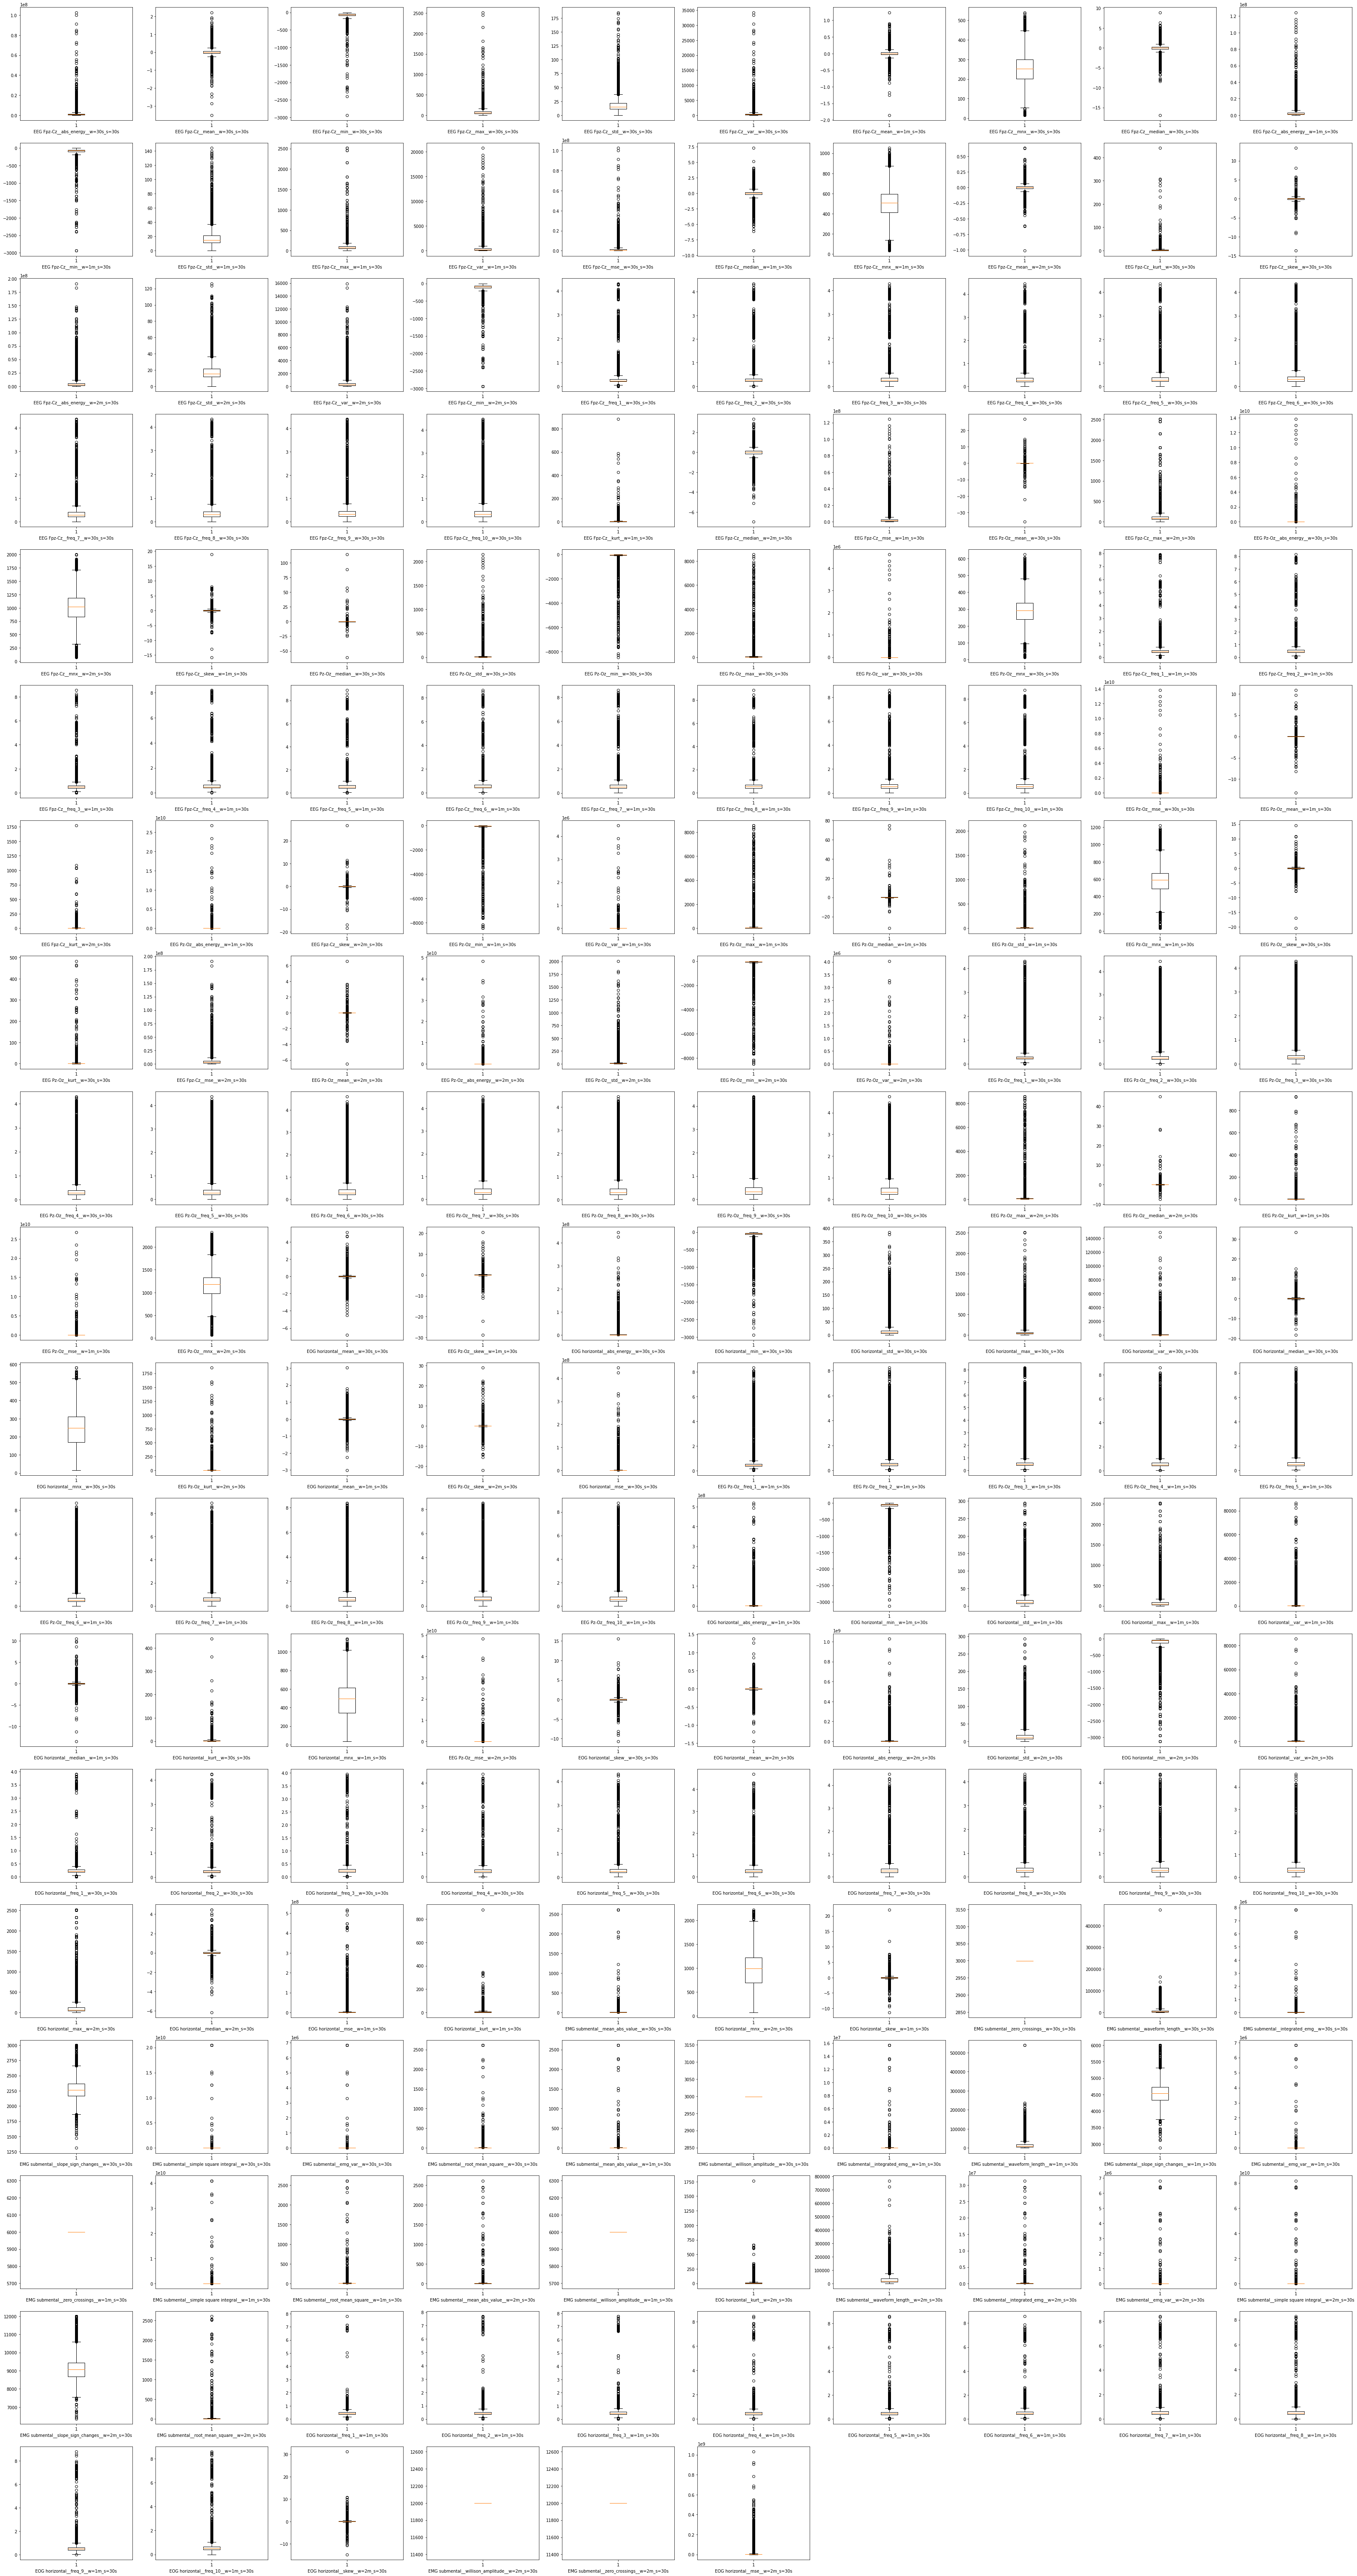

In [24]:
import math
import matplotlib.pyplot as plt

skip_cols = ["psg_file", "label"]
feat_cols = df_train.drop(columns=skip_cols).columns

n_cols = 10
n_rows = math.ceil(len(feat_cols) / n_cols)
plt.figure(figsize=(n_cols * 4.5, n_rows * 4.5))

for idx, col in enumerate(feat_cols):
    plt.subplot(n_rows, n_cols, idx + 1)
    plt.boxplot(df_train[col].dropna(), vert=True)
    plt.xlabel(col)

plt.tight_layout()
plt.show()

# ML

In [25]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import classification_report, balanced_accuracy_score, accuracy_score

## Logistic regression

Vanilla LR model, without any parameter tuning / feature reduction

In [26]:
from sklearn.linear_model import LogisticRegression

pipe = Pipeline(
    steps=[
        ("impute", SimpleImputer()),
        ("scale", StandardScaler()),
        ("lr", LogisticRegression(class_weight="balanced", n_jobs=6, max_iter=300, random_state=42))
    ]
)

pipe.fit(df_train[feat_cols], df_train["label"])

Pipeline(steps=[('impute', SimpleImputer()), ('scale', StandardScaler()),
                ('lr',
                 LogisticRegression(class_weight='balanced', max_iter=300,
                                    n_jobs=6, random_state=42))])

In [27]:
preds = pipe.predict(df_test[feat_cols])

print(classification_report(preds, df_test["label"]))

               precision    recall  f1-score   support

Sleep stage 1       0.63      0.39      0.48      1217
Sleep stage 2       0.64      0.96      0.76      2880
Sleep stage 3       0.98      0.50      0.66      1320
Sleep stage R       0.86      0.65      0.74      1910
Sleep stage W       0.70      0.84      0.76       595

     accuracy                           0.71      7922
    macro avg       0.76      0.67      0.68      7922
 weighted avg       0.75      0.71      0.70      7922



In [28]:
print(balanced_accuracy_score(preds, df_test["label"]))

0.6681574019419535


In [30]:
# Very bad metric, but appearantly many report it
print(accuracy_score(preds, df_test["label"]))

0.7111840444332239


## RF

RF model with some hyperparameter tuning

In [31]:
from sklearn.ensemble import RandomForestClassifier

pipe = Pipeline(
    steps=[
        ("impute", SimpleImputer()),
        ("scale", StandardScaler()),
        ("rf", RandomForestClassifier(n_estimators=75, max_depth=7, n_jobs=6, random_state=42))
    ]
)

In [34]:
grid = {
    "rf__n_estimators" : [25, 50, 75, 100],
    "rf__max_depth" : [5,7,9]
}

from sklearn.model_selection import GridSearchCV, GroupKFold

gkfold = GroupKFold(n_splits=6)
cv = gkfold.split(df_train, groups=df_train.psg_file)

grid = GridSearchCV(pipe, grid, n_jobs=5, scoring="f1_macro")
grid.fit(df_train[feat_cols], df_train["label"])

In [37]:
print(grid.best_score_)
print(grid.best_params_)

0.7117354767305842
{'rf__max_depth': 9, 'rf__n_estimators': 100}


In [38]:
pipe = grid.best_estimator_
pipe.fit(df_train[feat_cols], df_train["label"])

Pipeline(steps=[('impute', SimpleImputer()), ('scale', StandardScaler()),
                ('rf',
                 RandomForestClassifier(max_depth=9, n_jobs=6,
                                        random_state=42))])

In [39]:
preds = pipe.predict(df_test[feat_cols])

from sklearn.metrics import classification_report

print(classification_report(preds, df_test["label"]))

               precision    recall  f1-score   support

Sleep stage 1       0.36      0.64      0.46       431
Sleep stage 2       0.88      0.90      0.89      4252
Sleep stage 3       0.91      0.65      0.76       933
Sleep stage R       0.89      0.85      0.87      1515
Sleep stage W       0.88      0.79      0.83       791

     accuracy                           0.84      7922
    macro avg       0.78      0.77      0.76      7922
 weighted avg       0.86      0.84      0.84      7922



In [40]:
print(balanced_accuracy_score(preds, df_test["label"]))

0.7673982054988315


In [41]:
# Very bad metric, but appearantly many report it
print(accuracy_score(preds, df_test["label"]))

0.8361524867457713


### Benchmarking with sota

https://paperswithcode.com/sota/sleep-stage-detection-on-sleep-edf  
=> we keep up surprisingly well with the sota :)

**CONCLUSION**: While not optimizing the features, our macro F1 is really close to SOTA :)